# Resistance Subpopulation Model vs. Lytic Population Model

In [1]:
#import packages

import import_ipynb
import pandas as pd
import numpy as np
import random as rd
from scipy.integrate import odeint
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import PIL
from RSMfunctions import RSM
from RSMfunctions import solverR
from RSMfunctions import solver
from RSMfunctions import combined_variance
from RSMfunctions import orientdata19, orientdata26, maxvalue
from lyticfunctions import LPM, solverL

# set up dataframe display
pd.options.display.max_columns=1000

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
importing Jupyter notebook from RSMfunctions.ipynb
importing Jupyter notebook from lyticfunctions.ipynb


In [2]:
#Import Microcystis abundances
Microcystis_df = pd.read_csv(
    '../Data/MaLMM01 Batch Concentrations.csv')
Microcystis = Microcystis_df.astype(float)
Microcystis['Host26a26_log10']=np.log10(Microcystis['Host26a26'])
Microcystis['Host26a19_log10']=np.log10(Microcystis['Host26a19'])
Microcystis['Host19a26_log10']=np.log10(Microcystis['Host19a26'])
Microcystis['Host19a19_log10']=np.log10(Microcystis['Host19a19'])
print("Microcystis aeruginosa abundances: \n", Microcystis)

Microcystis aeruginosa abundances: 
    Day     Host26a26     Host26a19    Host19a26    Host19a19  Host26a26_log10  \
0  0.0  1.420016e+06  1.386509e+06  1400926.333  1394536.667         6.152293   
1  1.0  1.535596e+06  1.285988e+06  2171949.000  1815200.333         6.186277   
2  2.0  1.496973e+06  1.564002e+06  2196945.000  2199203.333         6.175214   
3  3.0  9.442783e+05  1.423130e+06  1419124.667  2439424.667         5.975100   
4  4.0  7.438033e+05  1.051991e+06  1620374.667  1763624.667         5.871458   
5  5.0  6.531250e+05  9.366787e+05  2015973.000  1781853.000         5.814996   
6  6.0  5.651557e+05  7.318073e+05  2721937.667  2287325.333         5.752168   
7  7.0  5.031790e+05  6.313983e+05  3509122.667  3065203.667         5.701723   
8  8.0  4.432190e+05  5.727367e+05  4395083.667  3864520.667         5.646618   

   Host26a19_log10  Host19a26_log10  Host19a19_log10  
0         6.141923         6.146415         6.144430  
1         6.109237         6.336850       

In [3]:
#Import Ma-LMM01 phage abundances
VLP = pd.read_csv(
    '../Data/VLP.csv')
VLP['VLP26a26_log10']=np.log10(VLP['VLP26a26'])
VLP['VLP26a19_log10']=np.log10(VLP['VLP26a19'])
VLP['VLP19a26_log10']=np.log10(VLP['VLP19a26'])
VLP['VLP19a19_log10']=np.log10(VLP['VLP19a19'])
print("Ma-LMM01 VLP abundances: \n", VLP)

Ma-LMM01 VLP abundances: 
    Day     VLP26a26     VLP26a19     VLP19a26     VLP19a19  VLP26a26_log10  \
0    0   10200000.0    9930000.0    4950000.0    6670000.0        7.008600   
1    4  163000000.0  119000000.0  148000000.0  154000000.0        8.212188   
2    8   97600000.0  162000000.0  367000000.0  346000000.0        7.989450   

   VLP26a19_log10  VLP19a26_log10  VLP19a19_log10  
0        6.996949        6.694605        6.824126  
1        8.075547        8.170262        8.187521  
2        8.209515        8.564666        8.539076  


# Resistant Subpopulation Model

In [5]:
"""This portion of code uses the resistant subpopulation model."""

mu = .36 
phi = 6e-08 
lamb = 0.65 
beta = 90 
Pr_S = 0.60 

#Define parameters for resistant host supopulation
muR = .44
phiR = 3e-9
lambR = 1,1,4,3.5
betaR = 60,60,150,180
Pr_R = np.round(np.arange(0, 1.1,.1),2) 

#Define initial conditions for the resistant population model
#Note these are derived from experimentally derived abundances
S0 = Microcystis['Host26a26'][0], Microcystis['Host26a19'][0],Microcystis['Host19a26'][0], Microcystis['Host19a19'][0]
I0 = 0
V0 = VLP['VLP26a26'][0],VLP['VLP26a19'][0],VLP['VLP19a26'][0],VLP['VLP19a19'][0]
R0 = 300000,250000,200000,150000,100000,50000,10000
R0_19 = 460000,400000,340000,280000,220000,160000,100000
IR0 = 0

#Define list of initial conditions that will be input into the ODE 
y0_26a26 = [[S0[0]-R0[i],I0,V0[0],R0[i],IR0] for i in range(7)]

y0_26a19 = [[S0[1]-R0[i],I0,V0[1],R0[i],IR0] for i in range(7)]

y0_19a26 = [[S0[2]-R0_19[i],I0,V0[2],R0_19[i],IR0] for i in range(7)]

y0_19a19 = [[S0[3]-R0_19[i],I0,V0[3],R0_19[i],IR0] for i in range(7)]

#Time domain
tmin,tmax = 0,8
delta = 0.001
nsteps = (tmax-tmin)/delta
t = np.linspace(tmin,tmax,int(nsteps))

#Perform ODE for host
host26a26_ode, host26a19_ode, host19a26_ode, host19a19_ode = [], [], [], []
np.array([host26a26_ode.append(solver(y0_26a26[i],mu,phi,beta,lamb,phiR,betaR[0],lambR[0],Pr_S,Pr_R)[0]) for i in range(7)])
np.array([host26a19_ode.append(solver(y0_26a19[i],mu,phi,beta,lamb,phiR,betaR[1],lambR[1],Pr_S,Pr_R)[0]) for i in range(7)])
np.array([host19a26_ode.append(solverR(y0_19a26[i],muR,phi,beta,lamb,phiR,betaR[2],lambR[2],Pr_S,Pr_R)[0]) for i in range(7)])
np.array([host19a19_ode.append(solverR(y0_19a19[i],muR,phi,beta,lamb,phiR,betaR[3],lambR[3],Pr_S,Pr_R)[0]) for i in range(7)])

#Perform ODE for virus
VLP26a26_ode, VLP26a19_ode, VLP19a26_ode, VLP19a19_ode = [], [], [], []
np.array([VLP26a26_ode.append(solver(y0_26a26[i],mu,phi,beta,lamb,phiR,betaR[0],lambR[0],Pr_S,Pr_R)[1]) for i in range(7)])
np.array([VLP26a19_ode.append(solver(y0_26a19[i],mu,phi,beta,lamb,phiR,betaR[1],lambR[1],Pr_S,Pr_R)[1]) for i in range(7)])
np.array([VLP19a26_ode.append(solverR(y0_19a26[i],muR,phi,beta,lamb,phiR,betaR[2],lambR[2],Pr_S,Pr_R)[1]) for i in range(7)])
np.array([VLP19a19_ode.append(solverR(y0_19a19[i],muR,phi,beta,lamb,phiR,betaR[3],lambR[3],Pr_S,Pr_R)[1]) for i in range(7)])

#define the host and virus 
host_26 =  Microcystis['Host26a26'],Microcystis['Host26a19'],Microcystis['Host26a26_log10'],Microcystis['Host26a19_log10']
host_19 = Microcystis['Host19a26'], Microcystis['Host19a19'], Microcystis['Host19a26_log10'],Microcystis['Host19a19_log10']
VLP_26 = VLP['VLP26a26'],VLP['VLP26a19'],VLP['VLP26a26_log10'],VLP['VLP26a19_log10']
VLP_19 = VLP['VLP19a26'], VLP['VLP19a19'], VLP['VLP19a26_log10'],VLP['VLP19a19_log10']


#Detemine Variance in model taking into account both the host and the virus
combinedvariances_26a26, combinedvariances_26a19, combinedvariances_19a26, combinedvariances_19a19 =[],[],[],[]
combineddf_26a26, combineddf_26a19, combineddf_19a26, combineddf_19a19 = [],[],[],[]
[combinedvariances_26a26.append(combined_variance(host_26[2],VLP_26[2],host26a26_ode[i][j], VLP26a26_ode[i][j],Microcystis,VLP)) for i in range(7) for j in range(11)]
[combinedvariances_26a19.append(combined_variance(host_26[3],VLP_26[3],host26a19_ode[i][j],VLP26a19_ode[i][j],Microcystis,VLP)) for i in range(7) for j in range(11)]
[combinedvariances_19a26.append(combined_variance(host_19[2],VLP_19[2],host19a26_ode[i][j],VLP19a26_ode[i][j],Microcystis,VLP)) for i in range(7) for j in range(11)]
[combinedvariances_19a19.append(combined_variance(host_19[3],VLP_19[3],host19a19_ode[i][j],VLP19a19_ode[i][j],Microcystis,VLP)) for i in range(7) for j in range(11)]
combined_split_variances_26a26 = np.array_split(combinedvariances_26a26, 7)
combined_split_variances_26a19 = np.array_split(combinedvariances_26a19, 7)
combined_split_variances_19a26 = np.array_split(combinedvariances_19a26, 7)
combined_split_variances_19a19 = np.array_split(combinedvariances_19a19, 7)
[combineddf_26a26.append(pd.DataFrame(combined_split_variances_26a26[i],columns=['Likelihood'])) for i in range(7)]
[combineddf_26a19.append(pd.DataFrame(combined_split_variances_26a19[i],columns=['Likelihood'])) for i in range(7)]
[combineddf_19a26.append(pd.DataFrame(combined_split_variances_19a26[i],columns=['Likelihood'])) for i in range(7)]
[combineddf_19a19.append(pd.DataFrame(combined_split_variances_19a19[i],columns=['Likelihood'])) for i in range(7)]

#Orient data in appropriate manner for output   
orientdata_26a26 = orientdata26(combineddf_26a26)
orientdata_26a19 = orientdata26(combineddf_26a19)
orientdata_19a26 = orientdata19(combineddf_19a26)
orientdata_19a19 = orientdata19(combineddf_19a19)

#Print the highest likelihood value achieved and at what phiR this occurs
print("The highest likelihood value for the 26a26 treatment is: ", (maxvalue(orientdata_26a26)[0]), "and occurs at a phiR of: ", (maxvalue(orientdata_26a26)[1]))
print("The highest likelihood value for the 26a19 treatment is: ", (maxvalue(orientdata_26a19)[0]), "and occurs at a phiR of: ", (maxvalue(orientdata_26a19)[1]))
print("The highest likelihood value for the 19a26 treatment is: ", (maxvalue(orientdata_19a26)[0]), "and occurs at a phiR of: ", (maxvalue(orientdata_19a26)[1]))
print("The highest likelihood value for the 19a19 treatment is: ", (maxvalue(orientdata_19a19)[0]), "and occurs at a phiR of: ", (maxvalue(orientdata_19a19)[1]))


The highest likelihood value for the 26a26 treatment is:  0.58 and occurs at a phiR of:  0.4
The highest likelihood value for the 26a19 treatment is:  0.89 and occurs at a phiR of:  0.6
The highest likelihood value for the 19a26 treatment is:  0.7 and occurs at a phiR of:  0.2
The highest likelihood value for the 19a19 treatment is:  0.89 and occurs at a phiR of:  0.2


# Plot the highest likelihoods found for the Resistance Subpopulation Model for each treatment.

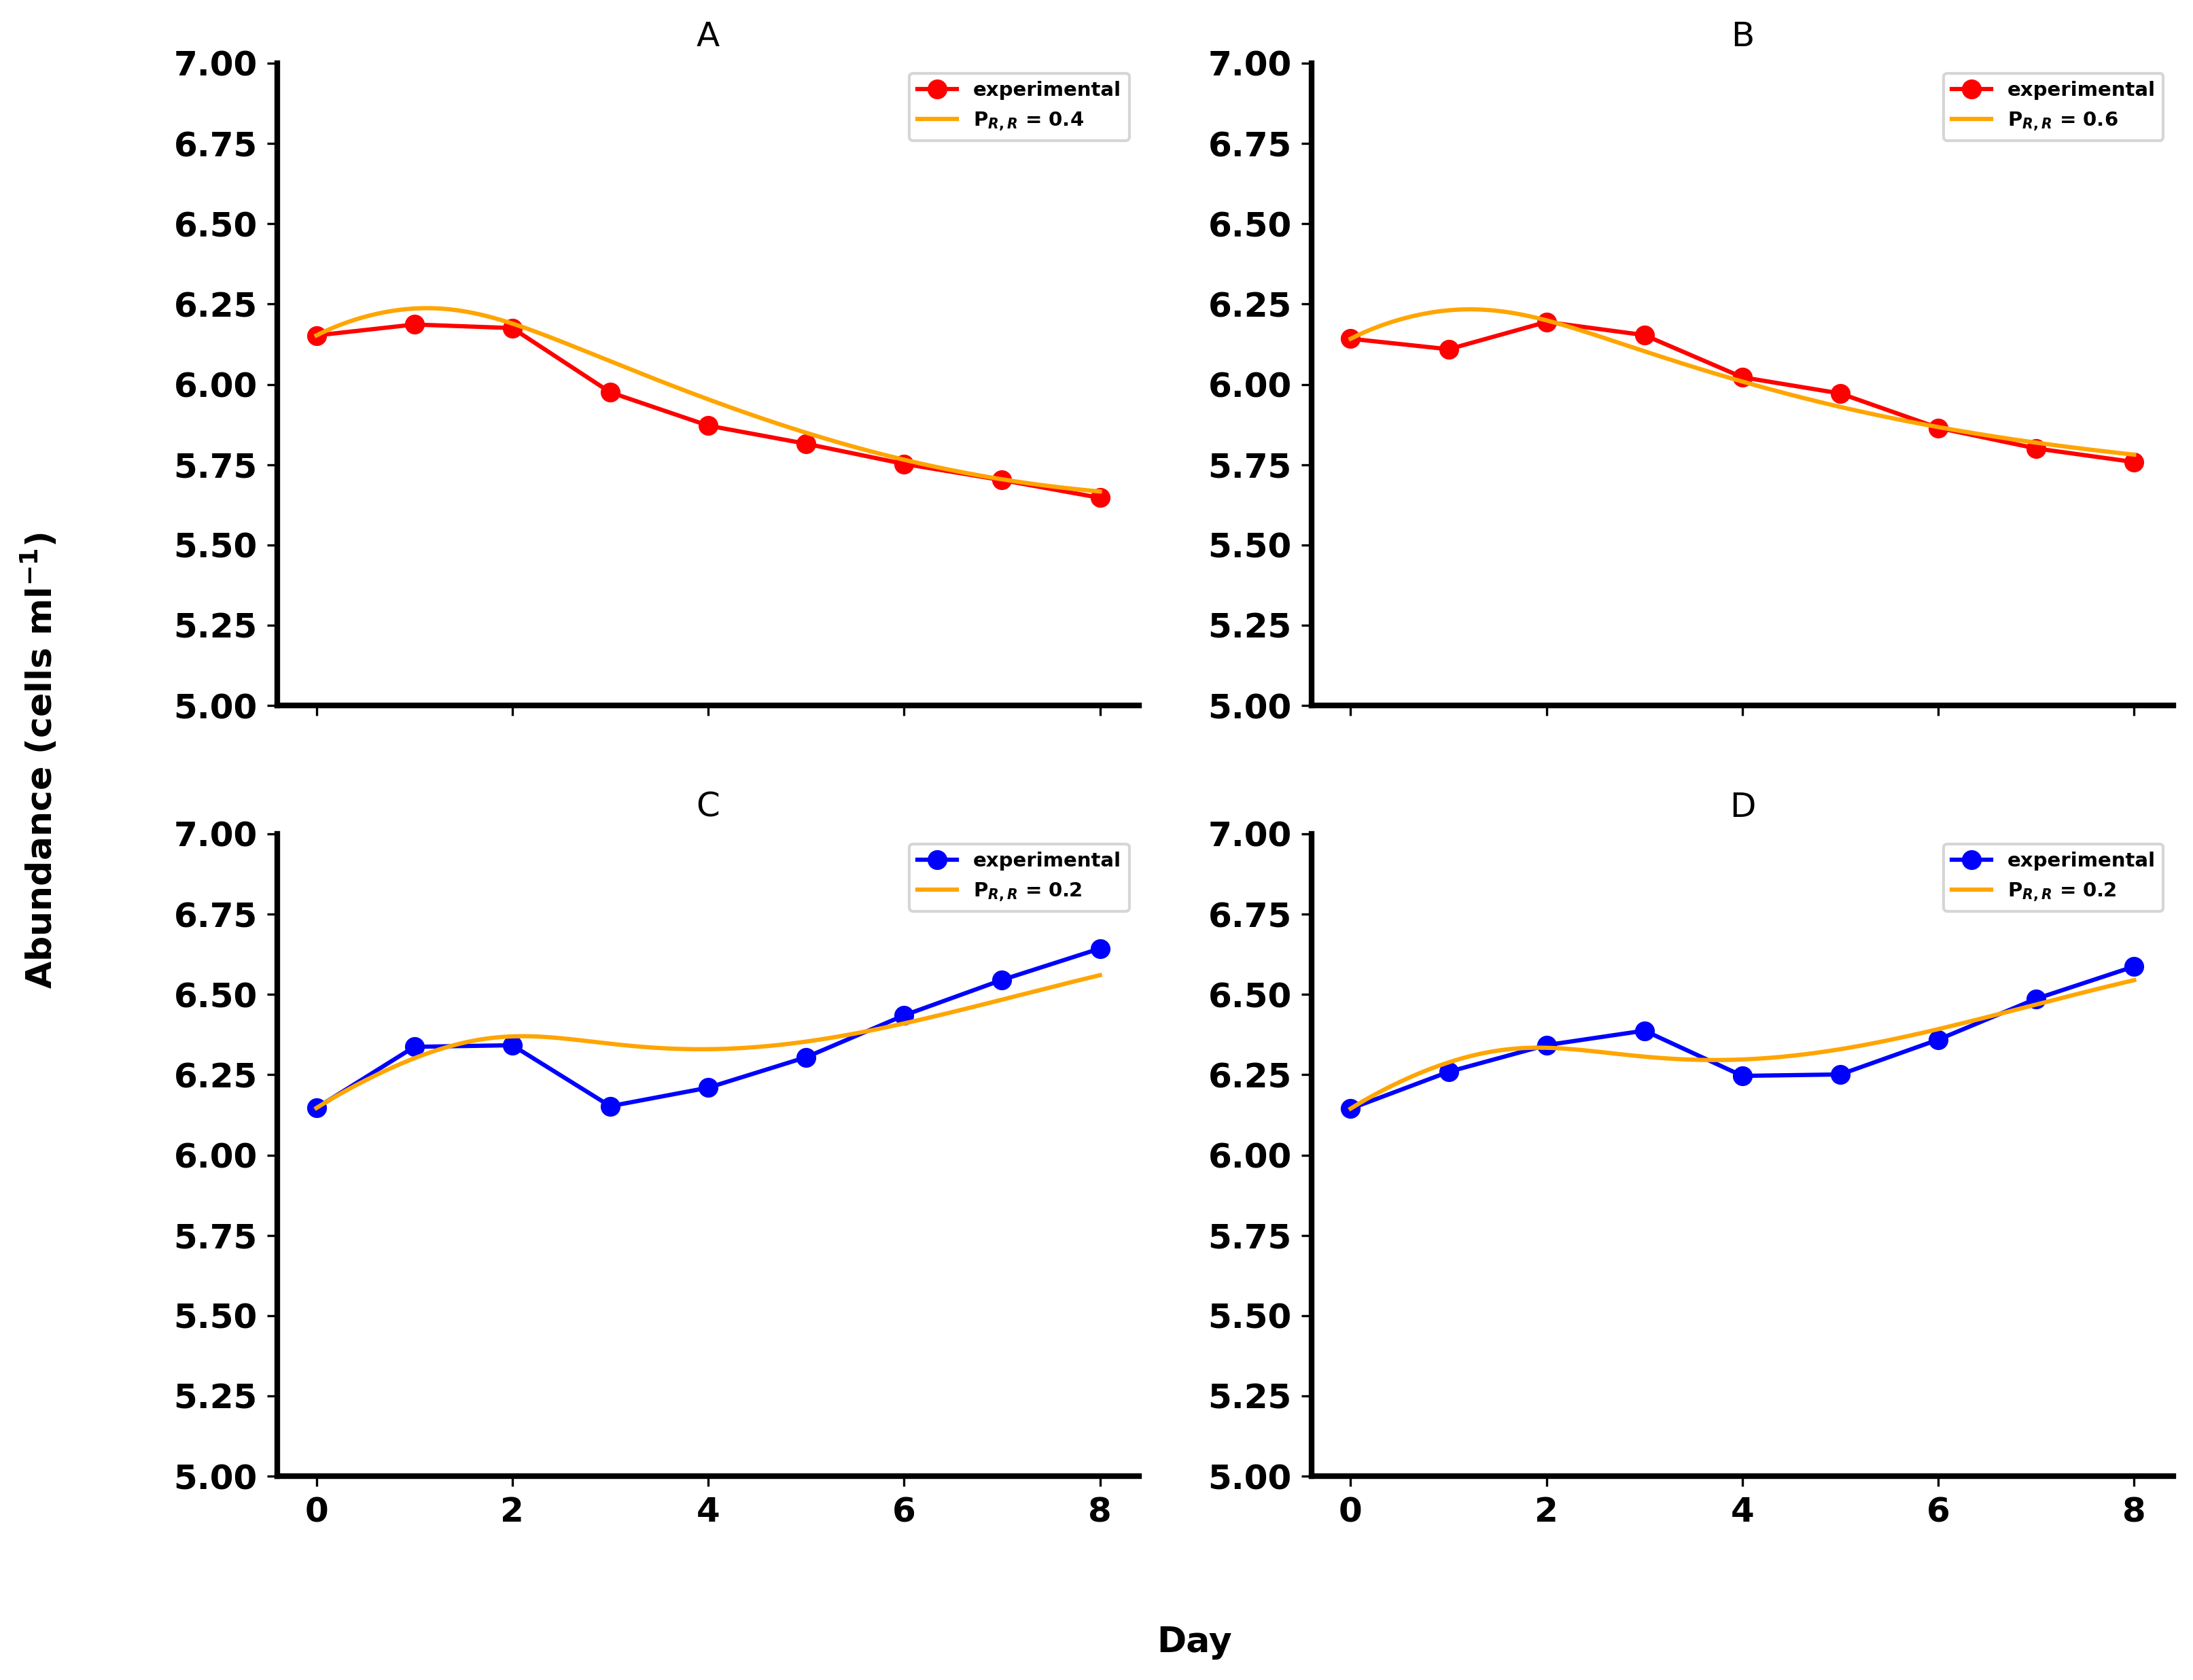

In [7]:
f,ax = plt.subplots(2,2,figsize=[12,9],sharex=True,dpi=300) # set up axes
ax[0,0].set_title("A")
ax[0,0].plot(Microcystis.Day, Microcystis.Host26a26_log10, 'red', marker='o',label='experimental')

ax[0,0].plot(t, host26a26_ode[5][4], 'orange', label='P$_{R,R}$ = 0.4') #best
ax[0,0].set_ylim([5, 7])

ax[0,1].set_title("B")
ax[0,1].plot(Microcystis.Day, Microcystis.Host26a19_log10, 'red', marker='o',label='experimental')

ax[0,1].plot(t, host26a19_ode[4][6], 'orange', label='P$_{R,R}$ = 0.6') #best
ax[0,1].set_ylim([5, 7])

ax[1,0].set_title("C")
ax[1,0].plot(Microcystis.Day, Microcystis.Host19a26_log10, 'blue', marker='o',label='experimental')

ax[1,0].plot(t, host19a26_ode[4][2], 'orange', label='P$_{R,R}$ = 0.2') #best
ax[1,0].set_ylim([5, 7])

ax[1,1].set_title("D")
ax[1,1].plot(Microcystis.Day, Microcystis.Host19a19_log10, 'blue', marker='o',label='experimental')

ax[1,1].plot(t, host19a19_ode[4][2], 'orange', label='P$_{R,R}$ = 0.2') #best
ax[1,1].set_ylim([5, 7])

for ax in ax.flat:
    ax.legend(loc='best',fontsize=7)
    ax.tick_params(labelsize=12)
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
fontproperties = {'family':'Times New Roman'}
f.supxlabel('Day', fontsize=12.5,fontweight='bold')
f.supylabel('Abundance (cells ml$^{-1}$)', fontsize=12.5, fontweight='bold')
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"
plt.show()


# Make Contour Plots to examine relationship between R and A.

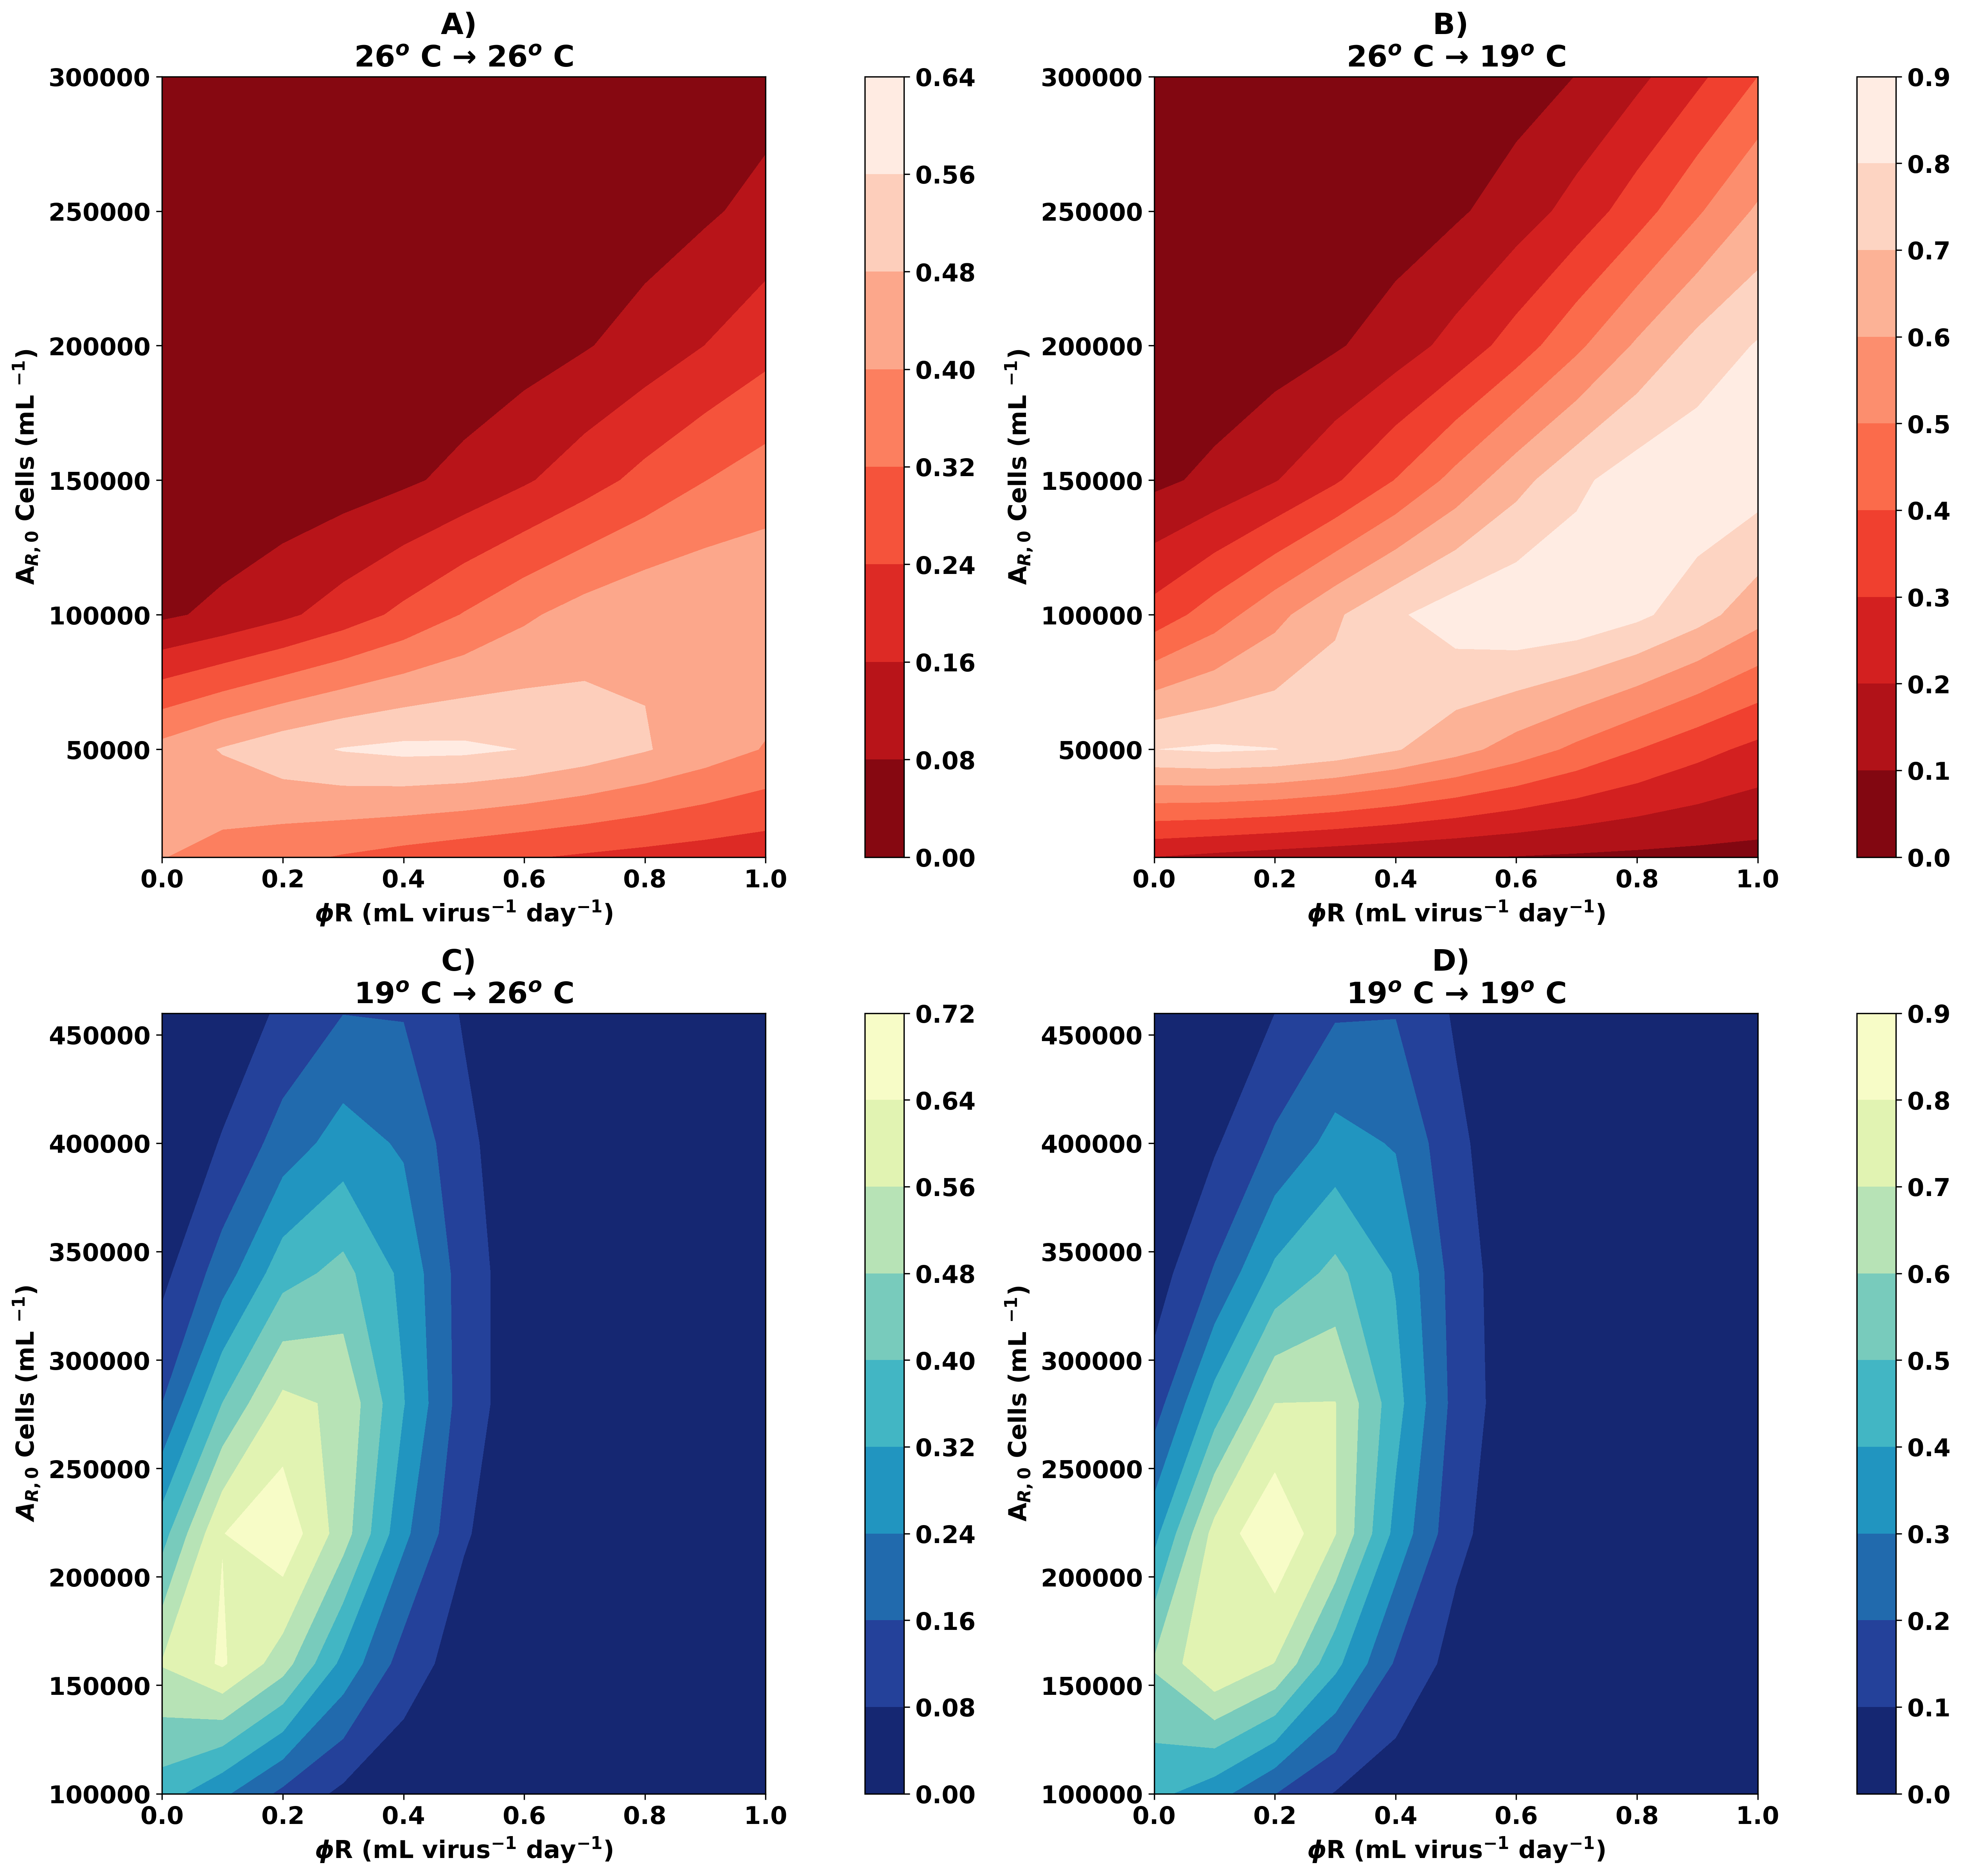

In [8]:
#Define variables for contour plots
x_26 = R0
x_19 = R0_19
y = Pr_R

import matplotlib as mpl
import matplotlib.cm as cm # matplotlib's color map library
import seaborn as sns

#R-Squared
zl_26a26 = orientdata26(combineddf_26a26)
zl_26a19 = orientdata26(combineddf_26a19)
zl_19a26 = orientdata19(combineddf_19a26)
zl_19a19 = orientdata19(combineddf_19a19)

#Initialize contour plot 
mpl.rcParams['font.size'] = 15
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.titlesize'] = 'small'
fig,ax = plt.subplots(2,2,figsize=(20, 19),dpi=300)

#Contours 26a26
cpf1 = ax[0,0].contourf(y,x_26, zl_26a26, 8, cmap=sns.color_palette("Reds_r",as_cmap=True))
cbar1 = fig.colorbar(cpf1, ax=ax[0,0],location="right",pad=0.12)

#Contours 26a19
cpf2 = ax[0,1].contourf(y,x_26, zl_26a19, 8, cmap=sns.color_palette("Reds_r",as_cmap=True))
cbar2 = fig.colorbar(cpf2, ax=ax[0,1],location="right",pad=0.12)

#Contours 19a26
cpf3 = ax[1,0].contourf(y,x_19,  zl_19a26, 8, cmap=sns.color_palette("YlGnBu_r",as_cmap=True))
cbar3 = fig.colorbar(cpf3, ax=ax[1,0],location="right",pad=0.12)

#Contours 19a19
cpf4 = ax[1,1].contourf(y,x_19, zl_19a19, 8, cmap=sns.color_palette("YlGnBu_r",as_cmap=True))
cbar4 = fig.colorbar(cpf4, ax=ax[1,1],location="right",pad=0.12)



ax[0,0].set_ylabel("A$_{R,0}$ Cells (mL $^{-1}$)")
ax[0,1].set_ylabel("A$_{R,0}$ Cells (mL $^{-1}$)")
ax[0,0].set_xlabel("$\phi$R (mL virus$^{-1}$ day$^{-1}$)")
ax[0,1].set_xlabel("$\phi$R (mL virus$^{-1}$ day$^{-1}$)")
ax[0,0].set_title("A) \n"  "26$^{o}$ C \u2192 26$^{o}$ C",fontweight='bold') #26a26 $^{o}$C R-squared"
ax[0,1].set_title("B) \n" "26$^{o}$ C \u2192 19$^{o}$ C",fontweight='bold') #26a19 $^{o}$C R-squared
ax[1,0].set_title("C) \n" "19$^{o}$ C \u2192 26$^{o}$ C",fontweight='bold') #19a26 $^{o}$C R-squared
ax[1,0].set_ylabel("$A_{R,0}$ Cells (mL $^{-1}$)")
ax[1,1].set_ylabel("A$_{R,0}$ Cells (mL $^{-1}$)")
ax[1,0].set_xlabel("$\phi$R (mL virus$^{-1}$ day$^{-1}$)")
ax[1,1].set_title("D) \n" "19$^{o}$ C \u2192 19$^{o}$ C",fontweight='bold') #19a19 $^{o}$C R-squared
ax[1,1].set_xlabel("$\phi$R (mL virus$^{-1}$ day$^{-1}$)")

fig.savefig('f4.png')
fig.savefig('Figure_4.tif')

# Lytic Population Model

In [9]:
"""This portion of code uses the lytic population model."""


#Define the parameters for the lytic population model
mu_L = .36,.24
phi_L =  np.array([6e-4,6e-5,6e-6,6e-7,6e-8,6e-9,6e-10,6e-11,6e-12,6e-13,6e-14,6e-15])
lamb_L = .65
beta_L = 90
Pr_L = 0.5,0.4,1,0.9

#Define a list of initial conditions that will be used in the ODE
y0_26a26L = [S0[0],I0,V0[0]]
y0_26a19L = [S0[1],I0,V0[1]]
y0_19a26L = [S0[2],I0,V0[2]]
y0_19a19L = [S0[3],I0,V0[3]]

#Perform the ODE using a lytic ODE 
Lhost26a26_ode = solverL(y0_26a26L,mu_L[0],phi_L,beta_L,lamb_L,Pr_L[0])[0]
Lhost26a19_ode = solverL(y0_26a19L,mu_L[0],phi_L,beta_L,lamb_L,Pr_L[1])[0]
Lhost19a26_ode = solverL(y0_19a26L,mu_L[1],phi_L,beta_L,lamb_L,Pr_L[2])[0]
Lhost19a19_ode = solverL(y0_19a19L,mu_L[1],phi_L,beta_L,lamb_L,Pr_L[3])[0]

LVLP26a26_ode = solverL(y0_26a26L,mu_L[0],phi_L,beta_L,lamb_L,Pr_L[0])[1]
LVLP26a19_ode = solverL(y0_26a19L,mu_L[0],phi_L,beta_L,lamb_L,Pr_L[1])[1]
LVLP19a26_ode = solverL(y0_19a26L,mu_L[1],phi_L,beta_L,lamb_L,Pr_L[2])[1]
LVLP19a19_ode = solverL(y0_19a19L,mu_L[1],phi_L,beta_L,lamb_L,Pr_L[3])[1]

#Determine model variance as defined by likelihood values taking into account both host and phage
variances_26a26L, variances_26a19L, variances_19a26L, variances_19a19L =[],[],[],[]
variancesdf_26a26L, variancesdf_26a19L, variancesdf_19a26L, variancesdf_19a19L =[],[],[],[]
variances_26a26L.append((combined_variance(host_26[2],VLP_26[2],Lhost26a26_ode[i],LVLP26a26_ode[i],Microcystis,VLP)) for i in range(len(phi_L)))
variances_26a19L.append((combined_variance(host_26[3],VLP_26[3],Lhost26a19_ode[i],LVLP26a19_ode[i],Microcystis,VLP)) for i in range(len(phi_L)))
variances_19a26L.append((combined_variance(host_19[2],VLP_19[2],Lhost19a26_ode[i],LVLP19a26_ode[i],Microcystis,VLP)) for i in range(len(phi_L)))
variances_19a19L.append((combined_variance(host_19[3],VLP_19[3],Lhost19a19_ode[i],LVLP19a19_ode[i],Microcystis,VLP)) for i in range(len(phi_L)))

#Add each likelihood into a dataframe 
variancesdf_26a26L = (pd.DataFrame(variances_26a26L,columns=[str(i) for i in phi_L]))
variancesdf_26a19L = (pd.DataFrame(variances_26a19L,columns=[str(i) for i in phi_L]))
variancesdf_19a26L = (pd.DataFrame(variances_19a26L,columns=[str(i) for i in phi_L]))
variancesdf_19a19L = (pd.DataFrame(variances_19a19L,columns=[str(i) for i in phi_L]))

#Print the dataframe output of the lytic models 
# print('Likelihood for 26a26 Lytic Model:\n', variancesdf_26a26L)
# print('Likelihood for 26a19 Lytic Model:\n', variancesdf_26a19L)
# print('Likelihood for 19a26 Lytic Model:\n', variancesdf_19a26L)
# print('Likelihood for 19a19  Lytic Model:\n', variancesdf_19a19L)

#Detemine the maximal likelihood for each model and the phi value this occurs at 
max_26a26L = maxvalue(variancesdf_26a26L)
max_26a19L = maxvalue(variancesdf_26a19L)
max_19a26L = maxvalue(variancesdf_19a26L)
max_19a19L = maxvalue(variancesdf_19a19L)

print("The highest likelihood value for the 26a26 LPM is: ", (max_26a26L[0]), "and occurs at a phi of: ", (max_26a26L[1]))
print("The highest likelihood value for the 26a19 LPM is: ", (max_26a19L[0]), "and occurs at a phi of: ", (max_26a19L[1]))
print("The highest likelihood value for the 19a26 LPM is: ", (max_19a26L[0]), "and occurs at a phi of: ", (max_19a26L[1]))
print("The highest likelihood value for the 19a19 LPM is: ", (max_19a19L[0]), "and occurs at a phi of: ", (max_19a19L[1]))


The highest likelihood value for the 26a26 LPM is:  0.42 and occurs at a phi of:  6e-08
The highest likelihood value for the 26a19 LPM is:  0.82 and occurs at a phi of:  6e-08
The highest likelihood value for the 19a26 LPM is:  0.01 and occurs at a phi of:  6e-09
The highest likelihood value for the 19a19 LPM is:  0.04 and occurs at a phi of:  6e-09


# Plot Lytic vs Resistant subpopulation models "best" fits

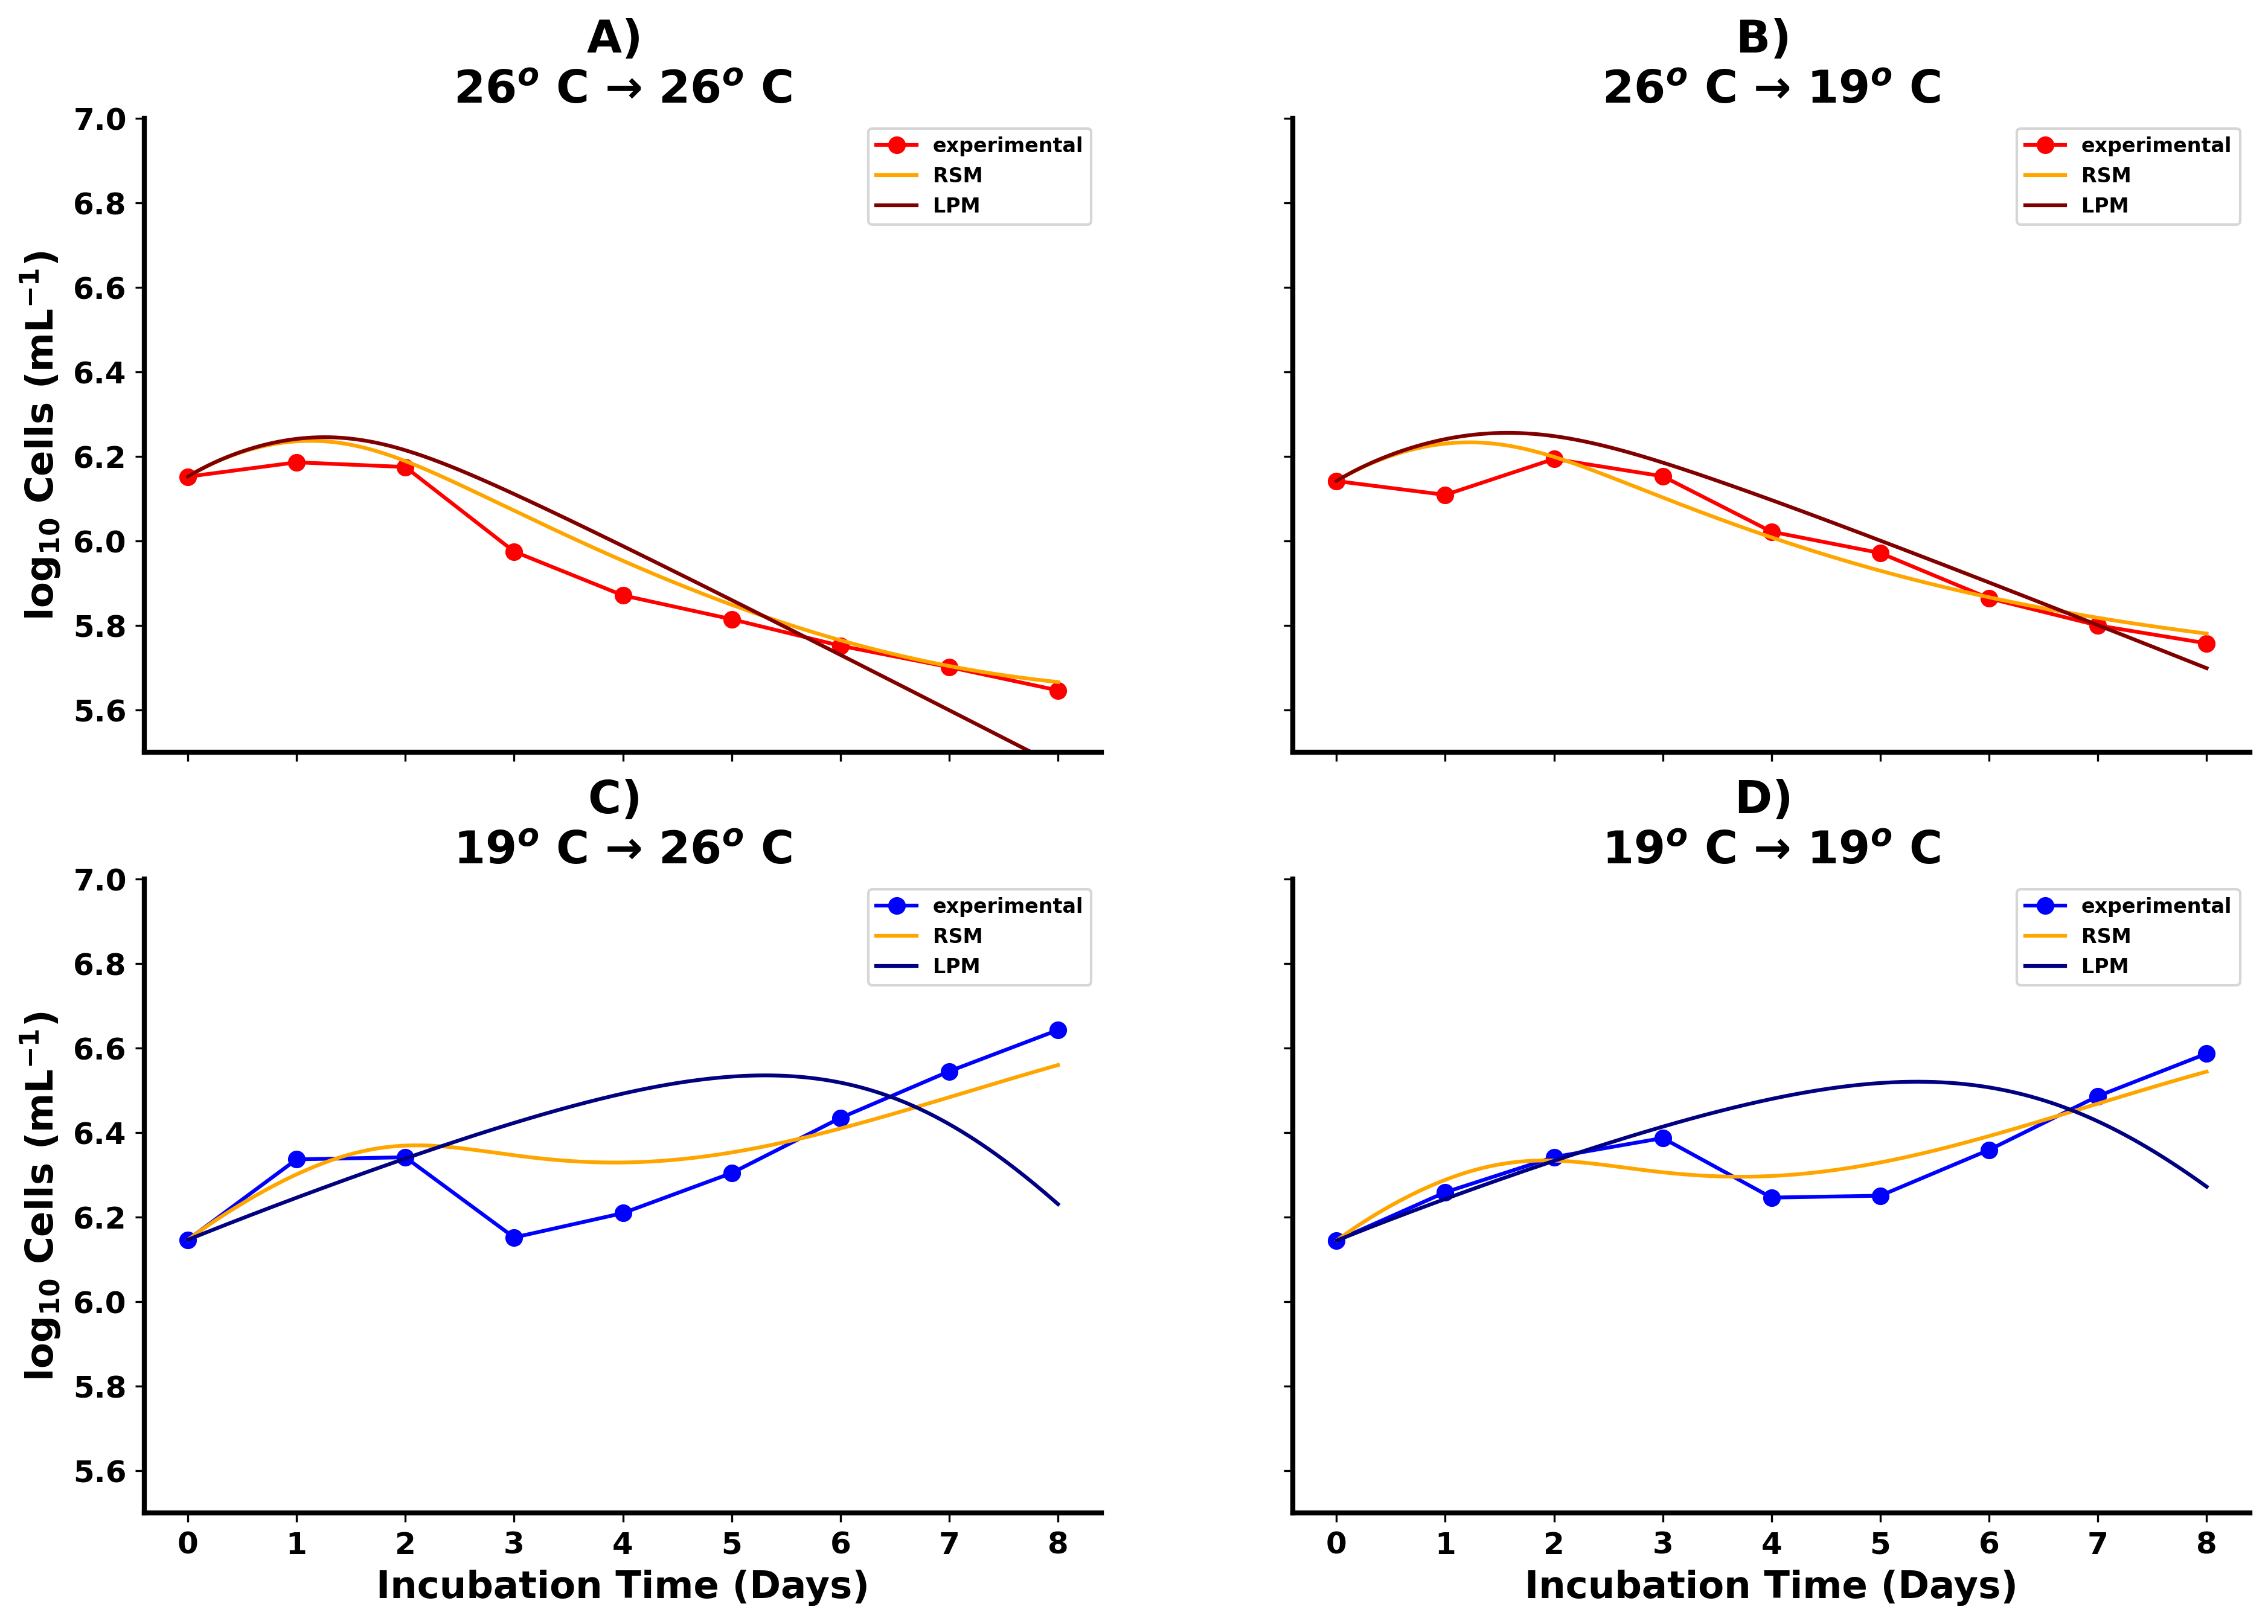

In [10]:
f,ax1 = plt.subplots(2,2,figsize=[15,10],sharex=True, sharey=True,dpi=300) # set up axes
ax1[0,0].set_title("A) \n"  "26$^{o}$ C \u2192 26$^{o}$ C",fontweight='bold')
ax1[0,0].set_ylabel('log$_{10}$ Cells (mL$^{-1}$)',fontweight='bold')
ax1[0,0].plot(Microcystis.Day, Microcystis.Host26a26_log10, 'red', marker='o',label='experimental') 
ax1[0,0].plot(t, host26a26_ode[5][4], 'orange', label='RSM') #Best Fit Resistant Subpopulation Model
ax1[0,0].plot(t, Lhost26a26_ode[4], 'maroon', label='LPM') #Best Fit Lytic population Model
ax1[0,0].set_ylim([5.5, 7])

ax1[0,1].set_title("B) \n" "26$^{o}$ C \u2192 19$^{o}$ C",fontweight='bold')
ax1[0,1].plot(Microcystis.Day, Microcystis.Host26a19_log10, 'red', marker='o',label='experimental')  #Resistant Subpopulation Model
ax1[0,1].plot(t, host26a19_ode[4][6], 'orange', label='RSM') #Best Fit Resistant Subpopulation Model
ax1[0,1].plot(t, Lhost26a19_ode[4], 'maroon', label='LPM') #Best Fit Lytic population Model
ax1[0,1].set_ylim([5.5, 7])

ax1[1,0].set_title("C) \n" "19$^{o}$ C \u2192 26$^{o}$ C",fontweight='bold')
ax1[1,0].set_ylabel('log$_{10}$ Cells (mL$^{-1}$)',fontweight='bold')
ax1[1,0].set_xlabel("Incubation Time (Days)",fontweight='bold')
ax1[1,0].plot(Microcystis.Day, Microcystis.Host19a26_log10, 'blue', marker='o',label='experimental')  #Resistant Subpopulation Model
ax1[1,0].plot(t, host19a26_ode[4][2], 'orange', label='RSM') #Best Fit Resistant Subpopulation Model
ax1[1,0].plot(t, Lhost19a26_ode[5], 'navy', label='LPM') #Best Fit Lytic population Model
ax1[1,0].set_ylim([5.5, 7])

ax1[1,1].set_title("D) \n" "19$^{o}$ C \u2192 19$^{o}$ C",fontweight='bold')
ax1[1,1].set_xlabel("Incubation Time (Days)",fontweight='bold')
ax1[1,1].plot(Microcystis.Day, Microcystis.Host19a19_log10, 'blue', marker='o',label='experimental') 
ax1[1,1].plot(t, host19a19_ode[4][2], 'orange', label='RSM') #Best Fit Resistant Subpopulation Model
ax1[1,1].plot(t, Lhost19a19_ode[5], 'navy', label='LPM') #Best Fit Lytic population Model
ax1[1,1].set_ylim([5.5, 7])

for ax in ax1.flat:
    ax.legend(loc='best',fontsize=8)
    ax.tick_params(labelsize=12)
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
fontproperties = {'family':'Arial'}
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"
plt.show()
f.savefig('f3.png')
f.savefig('Figure_3.tif')